After error neurons were selected, a differential latency analysis was performed. This was done by using a sliding window generalized linear model (GLM). The code below shows the functional implementation of the sliding GLM. 

In [1]:
# Install required packages
!pip install numpy scipy scikit-learn matplotlib seaborn statsmodels

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 16.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 8.2 MB/s eta 0:00:00
  Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)


In [10]:
import numpy as np
import scipy.io
import statsmodels.api as sm
import os
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

# Function to fit GLMs and perform likelihood ratio test
def fit_glm_and_test(spike_counts, outcomes, rt):
    if np.any(np.isnan(spike_counts)) or np.any(np.isinf(spike_counts)):
        print("Invalid spike counts detected.")
        return np.nan, np.nan

    if np.all(spike_counts == spike_counts[0]):
        print("No variation in spike counts.")
        return np.nan, np.nan

    try:
        X_full = sm.add_constant(np.column_stack((outcomes, rt)))
        glm_full = sm.GLM(spike_counts, X_full, family=sm.families.Poisson()).fit()

        X_null = sm.add_constant(rt)
        glm_null = sm.GLM(spike_counts, X_null, family=sm.families.Poisson()).fit()

        lr_stat = 2 * (glm_full.llf - glm_null.llf)
        p_value = chi2.sf(lr_stat, df=1)
        return lr_stat, p_value
    except Exception as e:
        print(f"Error during GLM fitting: {e}")
        return np.nan, np.nan

# Function to perform sliding-window GLM analysis
def sliding_window_glm(data, bin_size, step_size):
    answers = data['answers']
    colors_presented = data['colorsPresented']
    events = data['events']
    button_press_times = events[:, 1]
    rt = np.array(data['RTs'].flatten() * 1_000_000)
    timestamps = data['timestampsOfCell']

    outcomes = np.where(answers == colors_presented, 0, 1)

    stimulus_window = (-500_000, 1500_000)
    total_bins = int((stimulus_window[1] - stimulus_window[0]) / step_size) + 1

    lr_stats = []
    p_values = []

    for bin_idx in range(total_bins):
        spike_counts = []
        for trial_idx, button_press in enumerate(button_press_times):
            window_start = stimulus_window[0] + bin_idx * step_size - bin_size / 2
            window_end = stimulus_window[0] + bin_idx * step_size + bin_size / 2

            start = button_press + window_start
            end = button_press + window_end
            counts = np.sum((timestamps >= start) & (timestamps <= end))
            spike_counts.append(counts)

        spike_counts = np.array(spike_counts)
        lr_stat, p_value = fit_glm_and_test(spike_counts, outcomes, rt)
        lr_stats.append(lr_stat)
        p_values.append(p_value)

    significant = np.array(p_values) < 0.05
    differential_latency = None
    for i in range(len(significant) - 14):
        if np.all(significant[i:i + 15]):
            differential_latency = stimulus_window[0] + i * step_size
            break

    return lr_stats, p_values, differential_latency




The sliding glm was used to analyze all neurons that met previous qualifications as error neurons (p-value < 0.05 and len(error trials) >=5). To visual the differential latencies found in the sliding glm, the functions below were used to process the directories of error neurons in the AMY and HIP and visual the differential latencies per region. 

In [11]:
# Function to process a directory of .mat files
def process_directory(directory_path, bin_size, step_size):
    differential_latencies = []
    lr_stats_all = []

    for filename in os.listdir(directory_path):
        if filename.endswith('.mat'):
            file_path = os.path.join(directory_path, filename)
            print(f"Processing file: {file_path}")

            data = scipy.io.loadmat(file_path)
            lr_stats, _, differential_latency = sliding_window_glm(data, bin_size, step_size)

            if differential_latency is not None:
                differential_latencies.append(differential_latency / 1_000)
                lr_stats_all.append(lr_stats)

    return lr_stats_all, differential_latencies

In [12]:
# Function to plot differential latencies
def plot_differential_latencies(differential_latencies, plot_name):
    if len(differential_latencies) == 0:
        print("No differential latencies found.")
        return

    sorted_latencies = sorted(differential_latencies, reverse=True)
    median_differential_latency = np.median(sorted_latencies)

    plt.figure(figsize=(10, 6))
    plt.scatter(sorted_latencies, range(1, len(sorted_latencies) + 1), color='b', label="Differential Latency")
    plt.axvline(x=median_differential_latency, color='r', linestyle='--', label=f"Median: {median_differential_latency:.2f} ms")

    plt.xlabel("Differential Latency (ms)")
    plt.ylabel("Files (sorted by latency)")
    plt.title(plot_name+" Across Files")
    plt.legend()
    plt.grid(True)
    plt.savefig("outputs/"+plot_name+".png")
    plt.show()

# Function to plot a heatmap
def plot_heatmap_with_sorted_neurons(lr_stats, differential_latencies, plot_name):
    sorted_indices = np.argsort(differential_latencies)
    sorted_lr_stats = np.array(lr_stats)[sorted_indices]

    # Diagnostics to understand the data range
    max_lr = np.nanmax(sorted_lr_stats)

    # Define color scale limits using percentiles to avoid outliers
    vmax = max_lr*.35
    vmin = 0   # 1st percentile as lower limit

    # Create time bins from -500 ms to 1500 ms
    time_bins = np.linspace(-500, 1500, len(sorted_lr_stats[0]))
    
    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(sorted_lr_stats, cmap="YlOrRd", 
                cbar_kws={'label': 'Likelihood Ratio'}, vmin=vmin, vmax=vmax)

    # Set x-axis labels
    plt.xticks(ticks=np.linspace(0, len(time_bins) - 1, 5).astype(int), 
               labels=[f"{int(t)} ms" for t in np.linspace(-500, 1500, 5)], rotation=45)

    plt.title(plot_name + " of Likelihood Ratios Across Time")
    plt.xlabel("Time (ms)")
    plt.ylabel("Neuron/File")
    plt.savefig("outputs/"+plot_name+".png")
    plt.show()


Below is the code for executing the above functions to visualize the differential latency of error neurons per brain region.

Processing file: neurons/hip_error_neurons/s85ch61ba1c1.mat
Processing file: neurons/hip_error_neurons/s70ch5ba2c3.mat
Processing file: neurons/hip_error_neurons/s29ch1ba1c1.mat
Processing file: neurons/hip_error_neurons/s62ch19ba1c1.mat
Processing file: neurons/hip_error_neurons/s61ch19ba1c1.mat
Processing file: neurons/hip_error_neurons/s47ch25ba2c1.mat
Processing file: neurons/hip_error_neurons/s71ch5ba2c2.mat
Processing file: neurons/hip_error_neurons/s115ch58ba1c1.mat
Processing file: neurons/hip_error_neurons/s87ch26ba2c2.mat
Processing file: neurons/hip_error_neurons/s86ch31ba2c3.mat
Processing file: neurons/hip_error_neurons/s66ch4ba2c1.mat
Processing file: neurons/hip_error_neurons/s29ch5ba1c1.mat
Processing file: neurons/hip_error_neurons/s97ch26ba2c4.mat
Processing file: neurons/hip_error_neurons/s96ch29ba2c2.mat
Processing file: neurons/hip_error_neurons/s96ch62ba1c2.mat
Processing file: neurons/hip_error_neurons/s99ch57ba1c1.mat
Processing file: neurons/hip_error_neurons/s

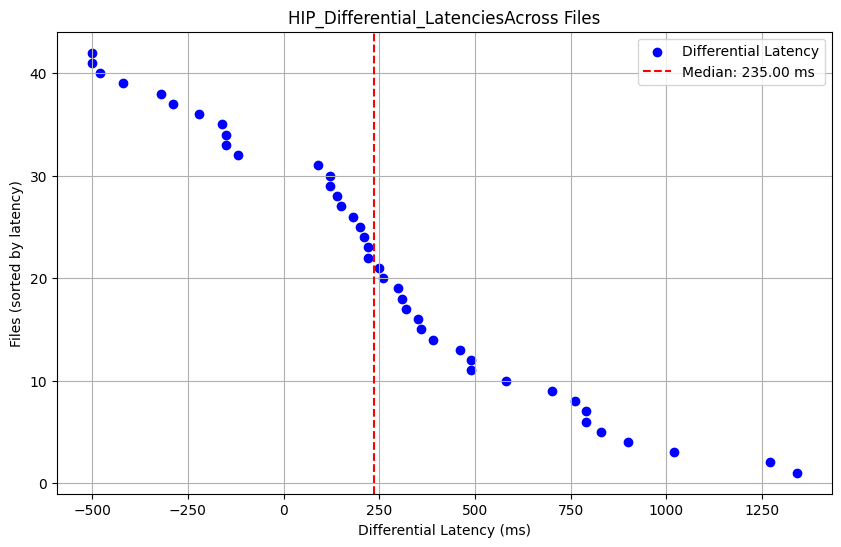

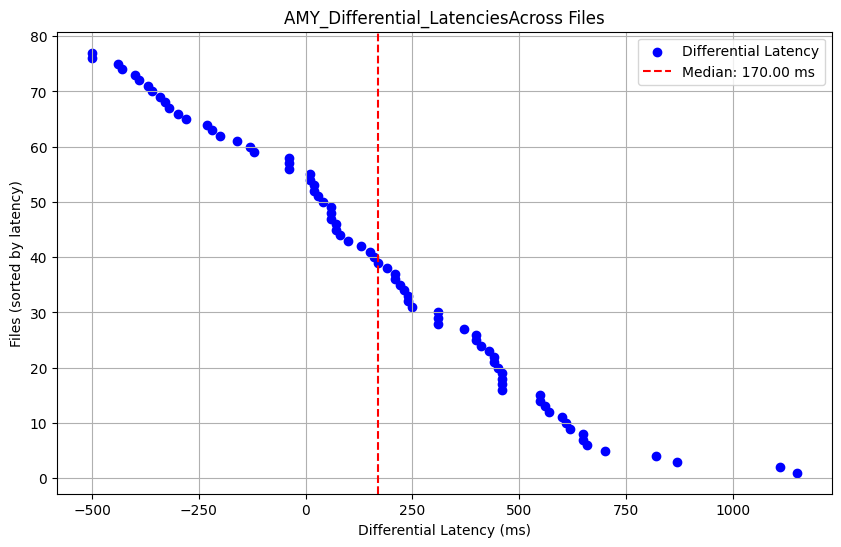

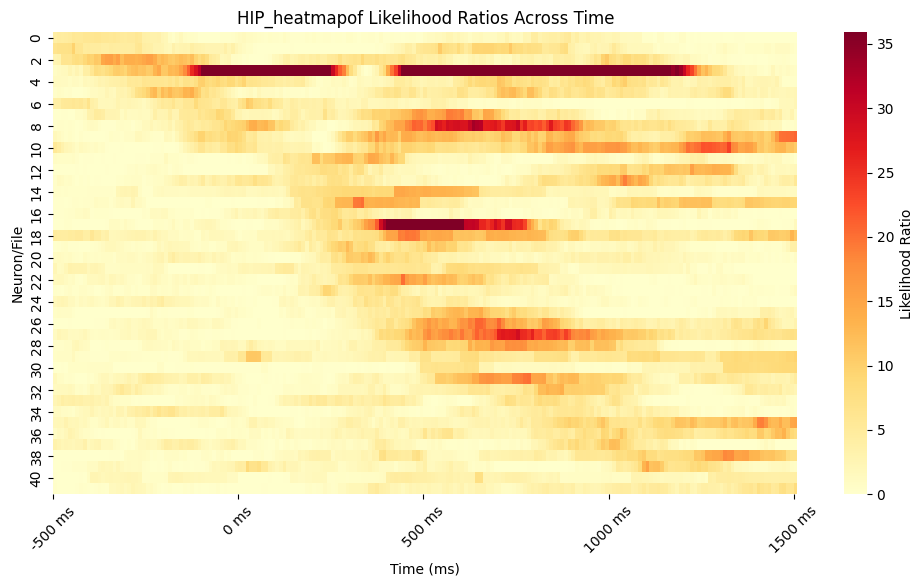

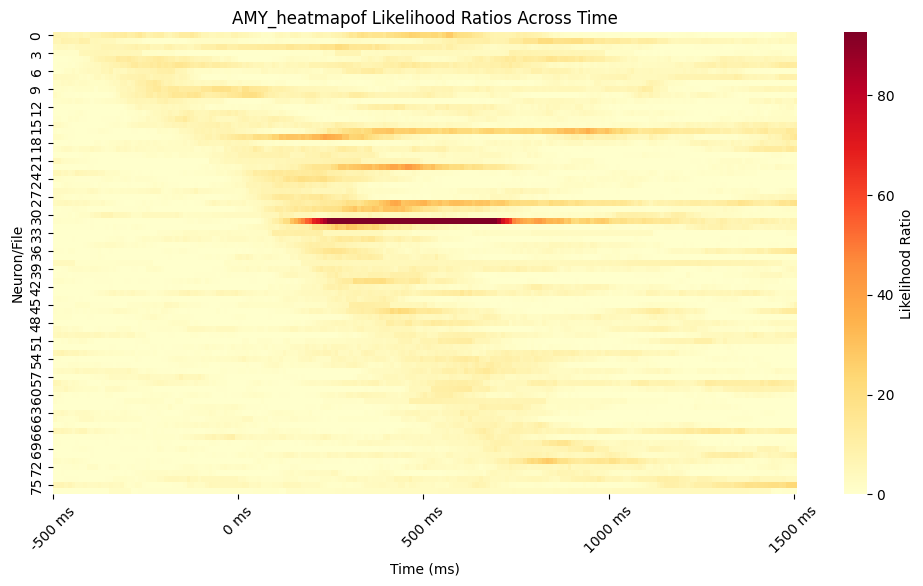

In [13]:
# Plotting the whole directory and a Heatmap
########################################################

bin_size = 400_000  # Bin size in microseconds
step_size = 10_000  # Step size in microseconds

directory_path_hip = 'neurons/hip_error_neurons/'
directory_path_amy = 'neurons/amy_error_neurons/'

lr_stats_all_hip, differential_latencies_hip = process_directory(directory_path_hip, bin_size, step_size)
lr_stats_all_amy, differential_latencies_amy = process_directory(directory_path_amy, bin_size, step_size)

plot_differential_latencies(differential_latencies_hip, plot_name='HIP_Differential_Latencies')
plot_differential_latencies(differential_latencies_amy, plot_name='AMY_Differential_Latencies')

plot_heatmap_with_sorted_neurons(lr_stats_all_hip, differential_latencies_hip, plot_name='HIP_heatmap')
plot_heatmap_with_sorted_neurons(lr_stats_all_amy, differential_latencies_amy, plot_name='AMY_heatmap')

